In [15]:
from datetime import datetime
from typing import List
import requests as req
from statistics import mean
from pandas import DataFrame
import matplotlib.pyplot as plt


In [16]:
class ChartCollectorAPI():
    def __init__(self):
        self.charts={}
        
    
    def get_chart(self,symbol:str,charts:List[str]=None,range:str="1mo") -> list:
        
        apiKeys = [{'x-api-key': "LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP"},{'x-api-key': "x0lGuGoAQMvr9Uweu7y62z0TwB0rHIx8eSxPwsV4"},{'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"},]
        
        for apiKey in apiKeys:
            print(f"API Key used :{apiKey}")
            headers = apiKey
        
            url = f"https://yfapi.net/v8/finance/chart/{symbol}?"
            if charts:
                url += "comparisons="
                for asset in charts:
                    url+= asset
                    if asset != (len(charts) - 1):
                        url+="%2C"
                url += "&"
            
            url+=f"range={range}&region=US&interval=1d&lang=en&events=div%2Csplit"
            
            response = req.request("GET", url, headers=headers)
            
            try:
                response = response.json()["chart"]["result"][0]
                timesamps = response["timestamp"]
                
                reference = response["indicators"]["quote"][0]["close"]
                
                # Adding reference chart
                if symbol not in self.charts and None not in reference:
                    self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, reference)]
                
                
                if charts:
                    comparison = response["comparisons"]
                    # Adding the comparisons charts
                    for value in comparison:
                        if value["symbol"] not in self.charts and None not in value["close"]:
                            self.charts[value["symbol"]]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, value["close"])]
                            
                
                return # If there is no exception raised, it means we managed to get the data

                
            
            except Exception as error:
                print(response.json())
                print("Trying with another api key...") # We continue the for loop
                
        print("There is no valid API key remaining ! ") # If there is no element in the for loop, we exit and tell the user the data hasn't been loaded
                
        
        
    """
    Methode pour charger le graphique d'un actif depuis l'api
    On verifie si l'actif n'a pas encore été chargé
    """
    def loading(self,list_actifs:List[str]):
        for actif in list_actifs:
            if actif not in self.charts:
               self.charts[actif]=self.get_chart(actif)
        
    """Methode qui sauvegarde les differents graphiques de comparaisons des différents actifs passés dans une liste en parametre
    Print dans la console les differentes distances en fonction de l'algorithme utilisé.
    """
    def resultats_rapports(self,actif_reference,charts) -> dict:
        results = {}
        
        
        
        chart_reference_datas = [value['close'] for value in charts[actif_reference]] #Recup prix de cloture
        
        
        # Les données mensuelles sont de taille 21 normalement 
        data_length = 21
        
        date_reference = charts[actif_reference][-data_length*2]['date'] #Recup la première date du graphique reference (WIP)
        
        # Le graphique de reference correspond a l'avant dernier mois (les 21 jours en commencant il y a 42 jours)
        chart_reference = chart_reference_datas[-data_length*2:-data_length]
        
        # Les données correspondant à ce qu'il s'est passé après soit les 21 derniers jours
        chart_reference_current_data = chart_reference_datas[-data_length:]
        
        # On le compare aux autres graphiques
        for actif_comparaison in charts:
            if actif_comparaison != actif_reference:
                
                # On recupere les données de comparaison
                chart_comparison = [{"close":value['close'],"date":value['date']} for value in charts[actif_comparaison]]


                # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                # On enleve le dernier mois et on garde les autres mois
                comparison_charts = [chart_comparison[:-data_length*2][x:x+data_length] for x in range(0, len(chart_comparison[:-data_length*2]), data_length)]
                

                # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                # On enleve le premier mois et on garde les autres mois
                reality_charts = [chart_comparison[data_length-1:-data_length][x:x+data_length] for x in range(0, len(chart_comparison[data_length-1:-data_length]), data_length)]
                
                    
                # Comparison correspond à un mois en partant du premier jusqu'à l'avant dernier, et current correspond au mois d'apres
                for comparison,current_data in zip(comparison_charts,reality_charts): #Zip ==> parcourir deux listes en même temps même vitesse
                    
                    # Si les deux graphiques n'ont pas la meme taille cela implique que l'on n'a pas exactement 21 jours dans le mois
                    # Il faut s'assurer que les mois de données actuelles sont de mêmes tailles(les données du mois suivant )(pour verifier la prediction)
                    if (len(comparison) ==len(chart_reference) and len(current_data) ==len(chart_reference_current_data)):
                        try:
                            data_comparison = [value["close"] for value in comparison]
                            distance = self.distance_point_par_point_rapport_moyenne(chart_reference,data_comparison)["distance moyenne"]
                        except Exception as error:
                            print(f"Erreur sur le rapport moyenne {actif_reference} /  {actif_comparaison} : {error} ")
                            raise error

                        date_comparison = comparison[0]["date"] 
                        results[f"resultat pour comparaison date: {date_comparison} {actif_reference} /  {actif_comparaison} "] = { #f string, pour évaluer un string
                            "value":distance,
                            "actif_reference":actif_reference,
                            "actif_comparaison":actif_comparaison,
                            "chart_reference":chart_reference, # starts 42 values ago
                            "chart_comparison":data_comparison,
                            "current_data_comparison":[value["close"] for value in current_data],
                            "current_data_reference":chart_reference_current_data, # starts 21 values ago
                            "date_reference":date_reference,
                            "date_comparison":comparison[0]["date"],
                            }
                    
        self.predictions=results
        return results                

    
    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison):          
         # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        try:
            rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        except:
            print(chart_reference)
        try:
            rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]
        except:
            print(chart_comparison)

        # On calcule les differentes distances entre les points des deux courbes
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]

        return {"distance moyenne":round(mean(distances),2)}
    
    def predict(self,symbol:str):
        analysis = self.resultats_rapports(symbol,self.charts)
        lowest = 1

        for value in analysis:
            if (analysis[value]["value"]<lowest):
                lowest = analysis[value]["value"]
                best_choice = analysis[value]
        
        self.best_prediction = best_choice
        
        current_data_comparison = best_choice["current_data_comparison"]
        current_data_reference = best_choice["current_data_reference"]
        chart_comparison = best_choice["chart_comparison"]
        chart_reference = best_choice["chart_reference"]

        prediction = current_data_comparison[len(current_data_comparison)-1]/mean(chart_comparison)*mean(chart_reference)

       
        print(f"Premier jour du mois de l'actif de comparaison : {best_choice['date_comparison']}")
        print(f"Premier jour du mois de l'actif de reference : {best_choice['date_reference']}")
        print(f"Predicted price : {prediction}   / Real price : {current_data_reference[-1]}")
        
    
    def plot_prediction(self,):
        if not self.best_prediction:
            print("There is no prediction to plot")
            return
            
        best_choice = self.best_prediction
        
        # On créé une nouvelle figure pour afficher le premier graphique
        plt.Figure(figsize=(5,5), dpi=100)
        ax = plt.subplot(111)
        ax.yaxis.label.set_color('red')

        # REFERENCE
        # On recupere les dates et les prix de l'actif 1
        dates = [index for index in range(len(best_choice["chart_reference"]))]
        prix = best_choice["current_data_reference"]

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()

        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax, color='r')


        # On recupere les dates et les prix de l'actif 1 ce qui s'est reellement passé 
        prix = best_choice["chart_reference"]
        dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()

        # On affiche le dataframe
        df.plot(linestyle='dashed',kind='line', legend=True, ax=ax, color='r')



        # COMPARAISON
        # On decoupe les ordonnées en deux categories distinctes pour les visualiser correctement
        ax2 = ax.twinx()
        # On change la couleur du label des ordonnées
        ax2.yaxis.label.set_color('b')

        # On recupere les dates et les prix de l'actif 2
        prix = best_choice["chart_comparison"]
        # On recupere les dates et les prix de l'actif 2
        dates = [index for index in range(len(best_choice["chart_comparison"]))]
        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])
        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax2, color='b')


        # On recupere les dates et les prix de l'actif 2 ce qui s'est reellement passé 
        prix = best_choice["current_data_comparison"]
        dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]
        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(linestyle='dashed',kind='line', legend=True, ax=ax2, color='b')

        ax.set_title('Prix des actions')

        plt.show()
    
    


https://yfapi.net/v8/finance/chart/AAPL?comparisons=MSFT%2CAPPL&range=1mo&region=US&interval=1d&lang=en&events=div%2Csplit

On charge le plus grand nombre d'actifs possibles

In [17]:
assets =[  
"MULN",
"SNDL",
"DRCT",
"NIO",
"HYMC",
"AMD",
"TLRY",
"AMC",
"AAPL",
"ADGI",
"AKBA",
"BRQS",
"MU",
"CLVR",
"NAOV",
"SOFI",
"NILE",
"ITUB",
"IMPP",
"SWN",
"DIDI",
"NVDA",
"RMO",
"BEKE",
"HOOD",
"BAC",
"VALE",
"CEI",
"DNA",
"SXTC",
"PLTR",
"NLY",
"WFC",
"BBIG",
"PBR",
"TELL",
"AAL",
"BABA",
"MSFT",
"PFE",
"EDU",
"BBD",
"OXY",
"TME",
"NOK",
"FB",
"NLSN",
"CCL",
"INTC",
"TMC",
"VYNT",
"SIRI",
"CHWY",
"UBER",
"TEVA",
"XOM",
"IBN",
"LCID",
"RIG",
"ISIG",
"AFRM",
"KGC",
"ZSAN",
"MEIP",
"CSCW",
"RIVN",
"RBLX",
"TSLA",
"GERN",
"ZNGA",
"XELA",
"XPEV",
"FCEL",
"FAMI",
"CALA",
"DKNG",
"PLUG",
"LAC",
"WWR",
"MRO",
"SNAP",
"PYPL",
"KMI",
"CLF",
"CSCO",
"TWTR",
"PROG",
"PDD",
"CENN",
"NKLA",
"CMCSA"]

Maintenant que nous avons recuperé les données, on va regarder celle qui ressemble le plus à AAPL

Find the best match

In [18]:
Analysis = ChartCollectorAPI()

assets_lists = [assets[x:x+10] for x in range(0, len(assets), 10)]

for asset in assets_lists[:2]:
    Analysis.get_chart(symbol=asset[0],charts=asset[1:],range="1y")

API Key used :{'x-api-key': 'LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP'}
API Key used :{'x-api-key': 'LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP'}


# On affiche les différents assets chargés

In [19]:
for asset in Analysis.charts:
    print(asset)

MULN
NIO
HYMC
SNDL
AMD
AKBA
MU
SOFI
CLVR
BRQS
NAOV


Premier jour du mois de l'actif de comparaison : 2021-11-02 14:30:00
Premier jour du mois de l'actif de reference : 2022-02-04 15:30:00
Predicted price : 0.70860087443338   / Real price : 2.7200000286102295


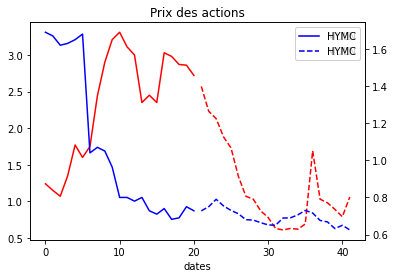

In [21]:
Analysis.predict("MULN")
Analysis.plot_prediction()